In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files

23-08-22 16:31:17    scales.py INF   Setting up healpy to run on 8 CPUs 


# v4 of the pipeline (multiple poisson noise realizations)

In [3]:
tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v4/debug/grid/DESy3_grid_000.tfrecord"
params = ["Om", "s8", "Aia", "bg", "n_Aia", "n_bg"]

grid_pipe = GridPipeline(
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False
)

23-08-22 16:31:18     files.py INF   Loaded the pixel file /cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-08-22 16:31:18     files.py INF   Loaded the pixel file /cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


2023-08-22 16:31:18.861541: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3

### compare noise realizations to noiseless

In [5]:
dvs_noisy = []

for i in range(n_noise):
    noisy_grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        i_noise=i,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
    )
    
    # get a single batch
    for data_vector, cosmo, index in noisy_grid_dset.take(1):
        dvs_noisy.append(data_vector)
        
dvs_noisy = np.concatenate(dvs_noisy, axis=0)

23-08-22 16:31:19 grid_pipelin INF   Batching into 1 elements locally 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-08-22 16:31:20 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-08-22 16:31:22 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'kg', 'dg']) 
23-08-22 16:31:22 grid_pipelin INF   Successfully generated the grid set with element_spec (TensorSpec(shape=(None, 464896, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))) for i_noise = 0 
23-08-22 16:31:22 grid_pipelin INF   Batching into 1 elements locally 
23-08-22 16:31:22 grid_pipelin WAR   Tracing _augmentations 
23-08-22 16:31:22 grid_pipelin INF   Running o

In [6]:
reso = 600

gnoms = np.zeros((len(dvs_noisy), reso, reso, n_z))

for i_n in range(len(dvs_noisy)):
    for i_z in range(n_z):
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

        gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=1, xsize=reso, ysize=reso, return_projected_map=True, no_plot=True)
        gnoms[i_n, ..., i_z] = gnom

gnoms = np.ma.masked_where(gnoms==0, gnoms)

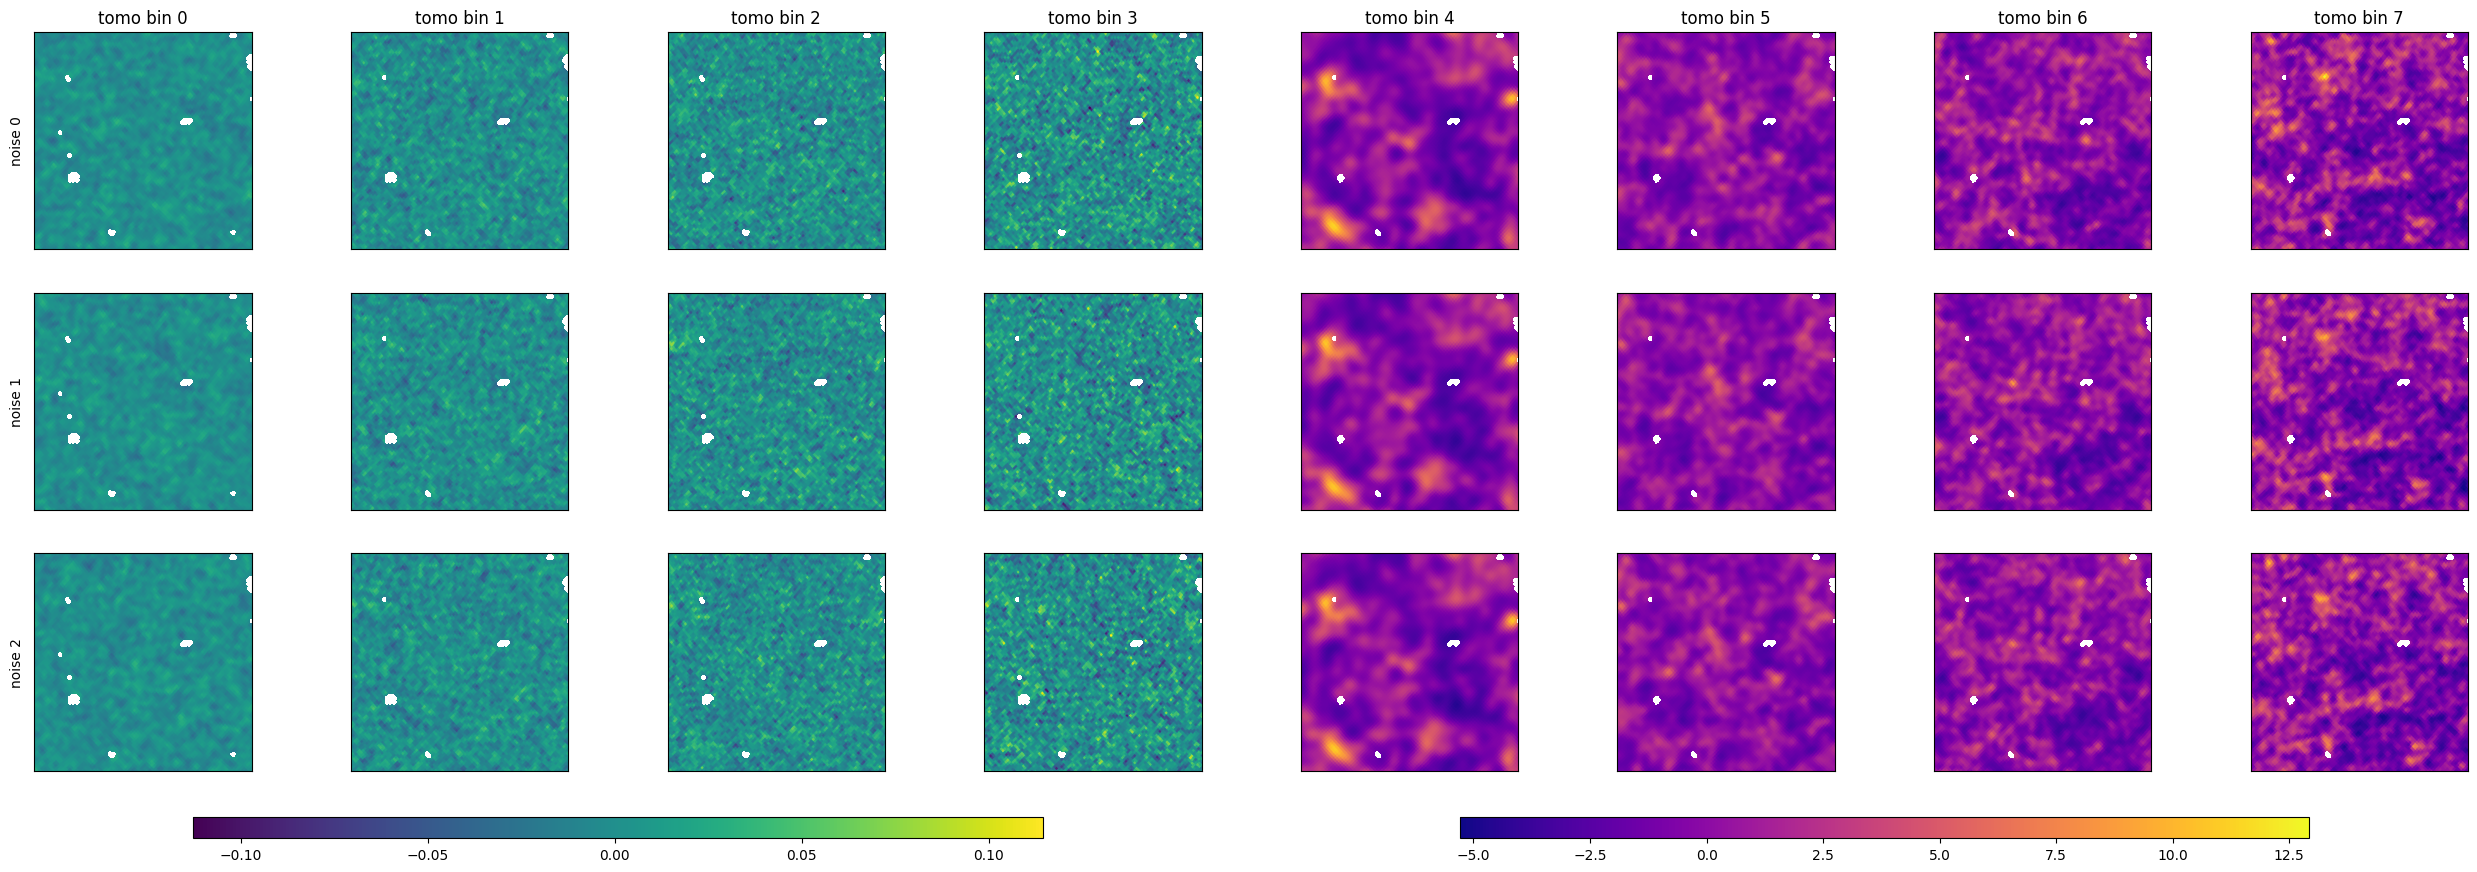

In [7]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*n_noise), nrows=n_noise, ncols=n_z)

vmin = np.array(gnoms).min()
vmax = np.array(gnoms).max()

wl_min = np.array(gnoms[...,:n_z_metacal]).min()
wl_max = np.array(gnoms[...,:n_z_metacal]).max()

gc_min = np.array(gnoms[...,n_z_metacal:]).min()
gc_max = np.array(gnoms[...,n_z_metacal:]).max()

for i_n, gnom in enumerate(gnoms):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"

        gnom = gnoms[i_n, ..., i_z]
        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n}")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 1:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/raw_maps.png", bbox_inches="tight", dpi=100)